In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [78]:
model_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231209/WARW_loss_0.09873973578214645_ml_output_WARW.parquet"

In [79]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [80]:
station = "WARW"

In [81]:
def ml_output(df, fold, station):
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(df["target_error_lead_0"], c="r", label="Target")
    plt.plot(df["Model forecast"], c="b", alpha=0.7, label="LSTM Output")
    plt.axvline(
        x=(int(0.2 * len(df["target_error_lead_0"])) * fold),
        c="green",
        linestyle="--",
        linewidth=2.0,
        label="Test Set Start",
    )
    plt.axvline(
        x=(int(0.2 * len(df["target_error_lead_0"])) * (fold + 1)),
        c="red",
        linestyle="--",
        linewidth=2.0,
        label="Test Set Finish",
    )
    ax.set_title(f"LSTM Output v Target: {station}", fontsize=28)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(
        np.arange(
            0, (len(df["Model forecast"]) + 1), ((len(df["Model forecast"]) + 1) / 5)
        )
    )
    ax.legend()

/tmp/tmp.gnc0EOpIsY/ipykernel_3335463/3139970572.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


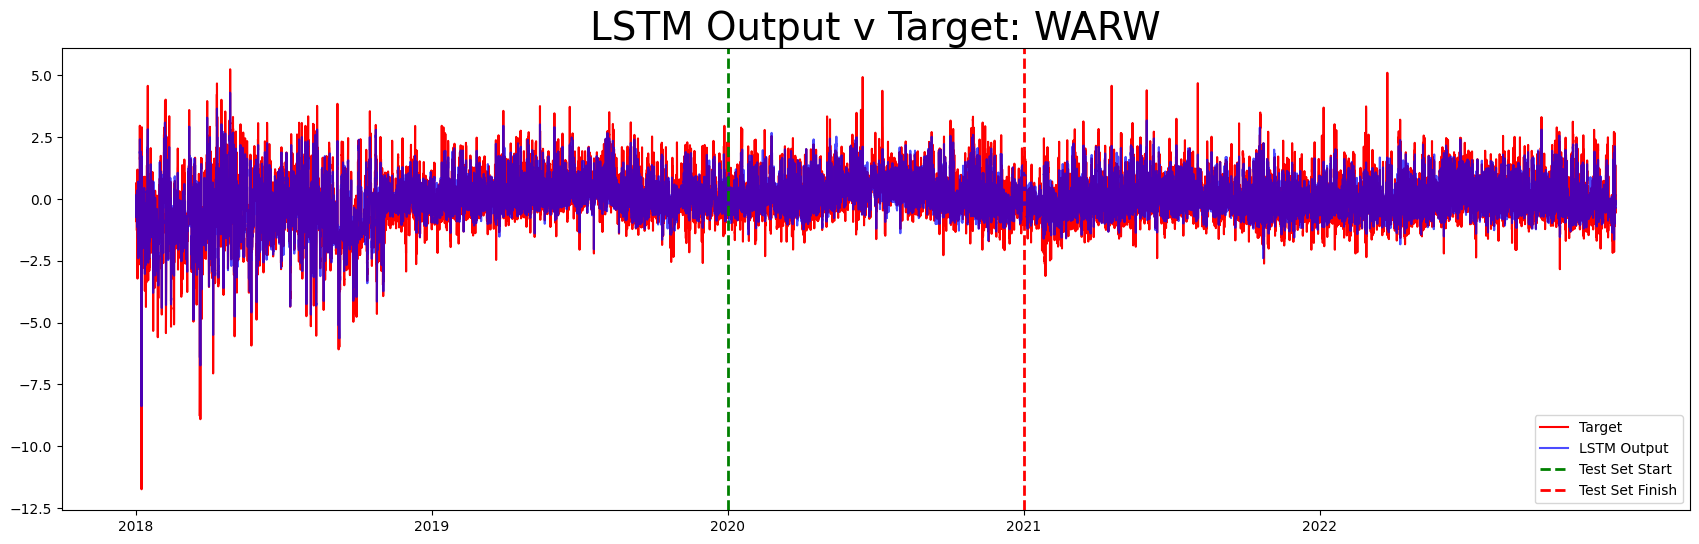

In [82]:
ml_output(df, 2, station)

In [83]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/12_09_2023_16:21:04_full_WARW.parquet"
)

In [84]:
full_df["Abs_err"] = df["diff"]

In [85]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [86]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [87]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 5)))
    return the_list

/tmp/tmp.gnc0EOpIsY/ipykernel_3335463/3317699654.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


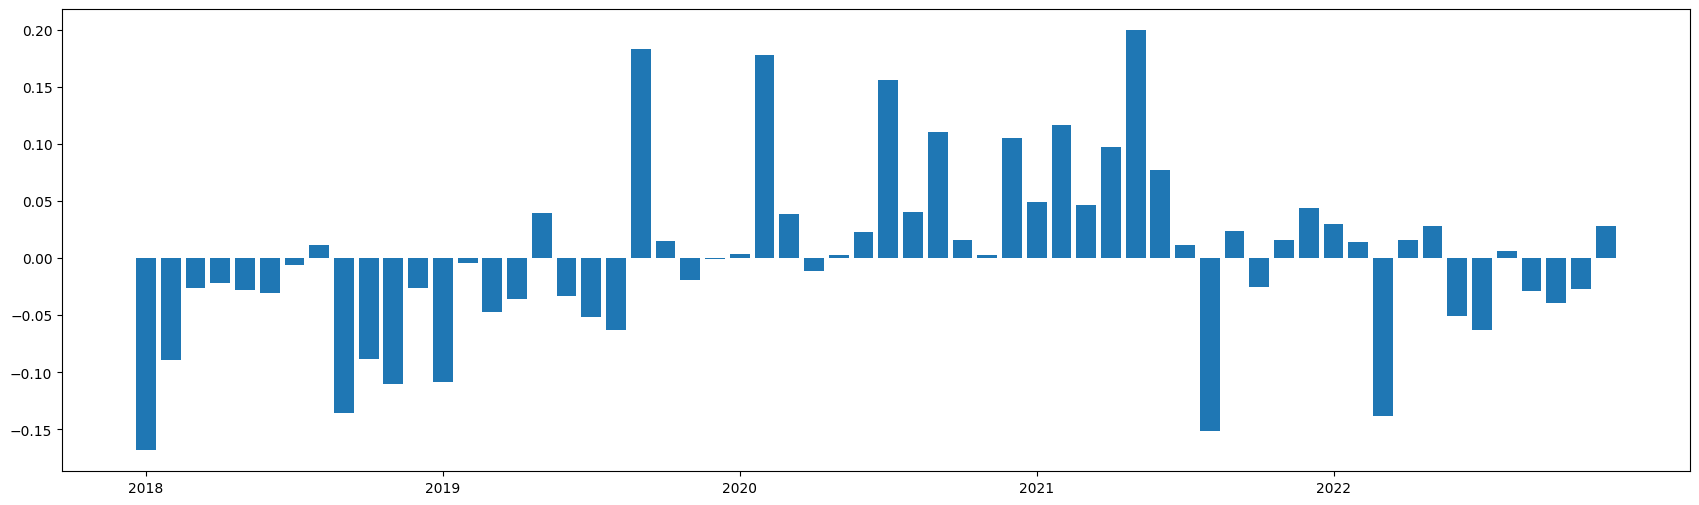

In [88]:
err_by_month = groupby_month(full_df, "Abs_err")

In [89]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

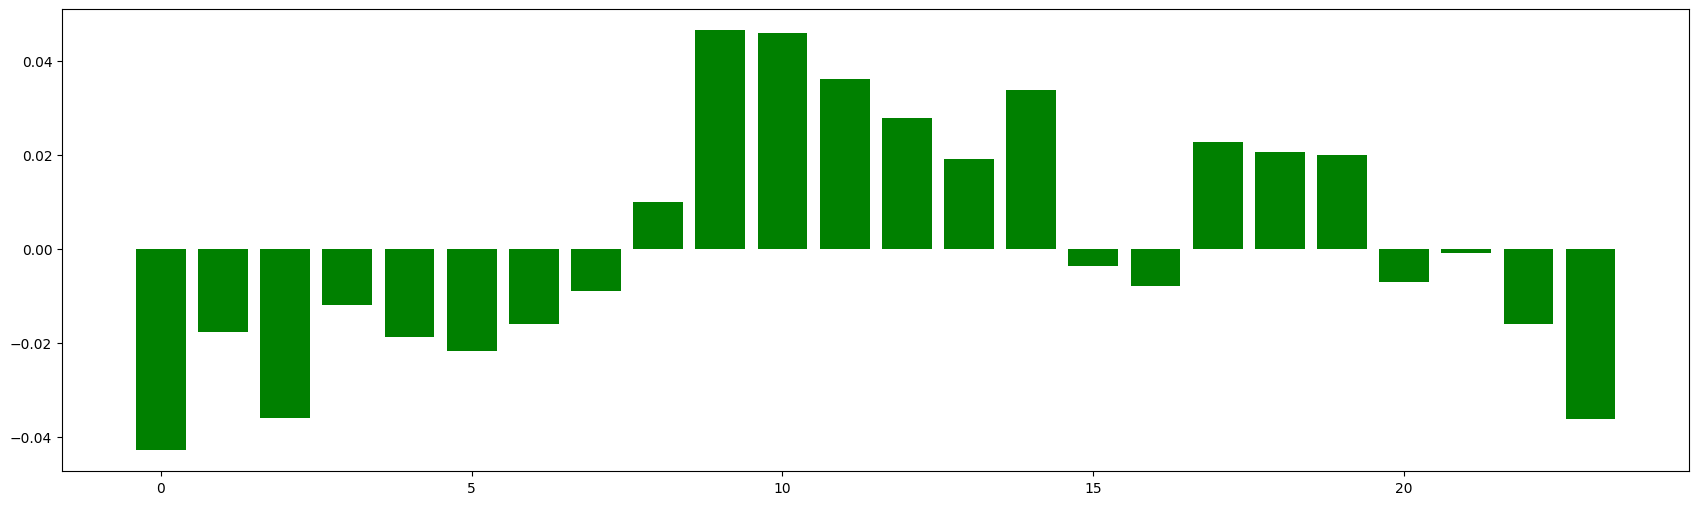

In [90]:
err_by_time = groupby_time(full_df, "Abs_err")

In [91]:
def myround(x, base):
    return base * round(x / base)

In [92]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [93]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [94]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(figsize=(21, 6), facecolor="slategrey", layout="compressed")
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [95]:
for k in full_df.keys():
    print(k)

valid_time
valid_time_cos
valid_time_sin
t2m_WARW
sh2_WARW
d2m_WARW
r2_WARW
u10_WARW
v10_WARW
tp_WARW
mslma_WARW
orog_WARW
tcc_WARW
asnow_WARW
cape_WARW
dswrf_WARW
dlwrf_WARW
gh_WARW
u_total_WARW
u_dir_WARW
new_tp_WARW
lat_WARW
lon_WARW
elev_WARW
tair_WARW
ta9m_WARW
td_WARW
relh_WARW
srad_WARW
pres_WARW
mslp_WARW
wspd_sonic_WARW
wmax_sonic_WARW
wdir_sonic_WARW
precip_total_WARW
snow_depth_WARW
Abs_err


In [96]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

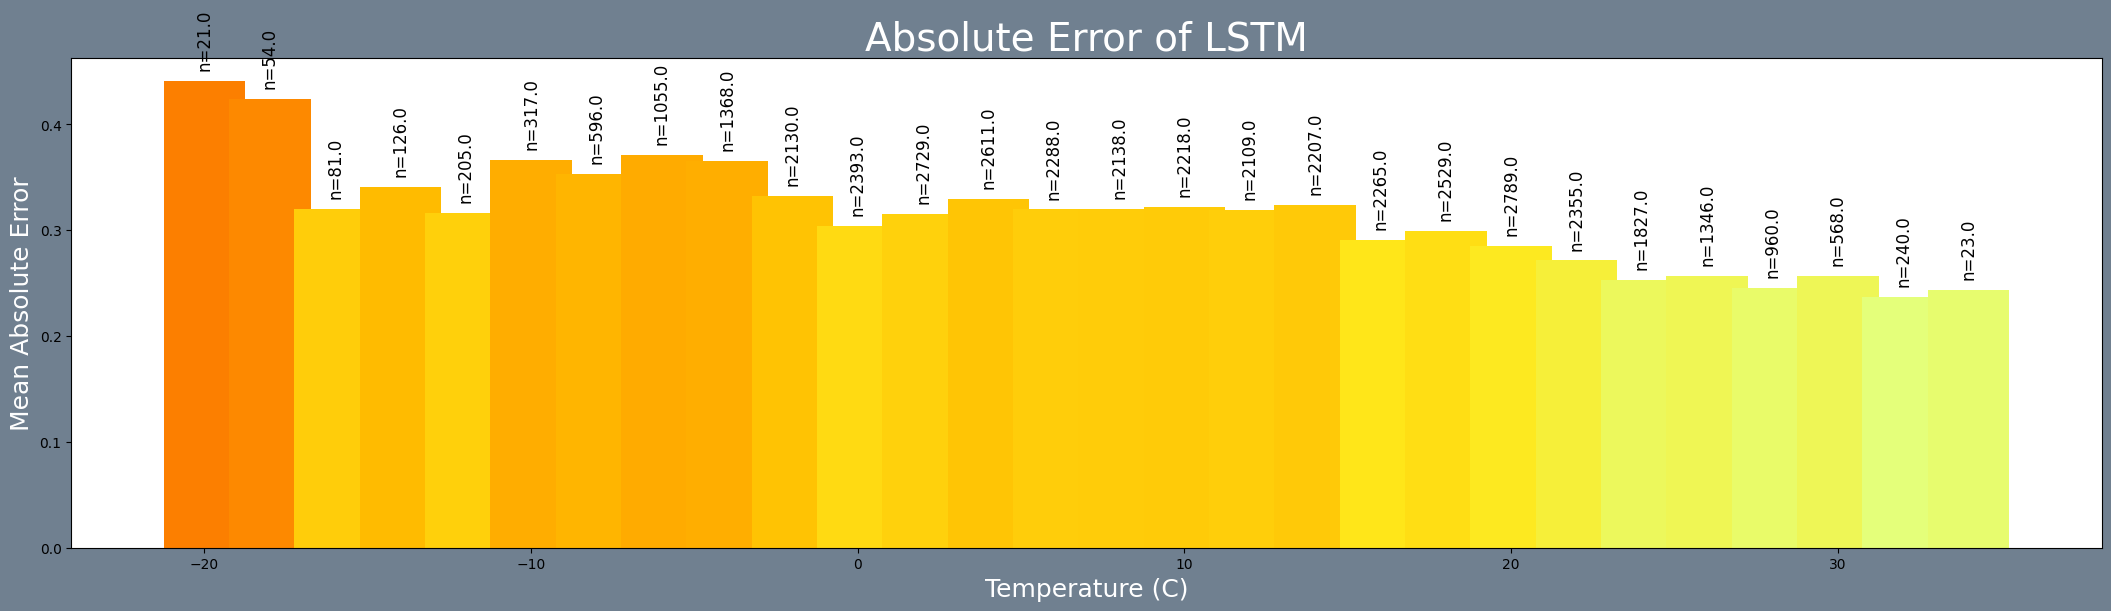

In [97]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [98]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

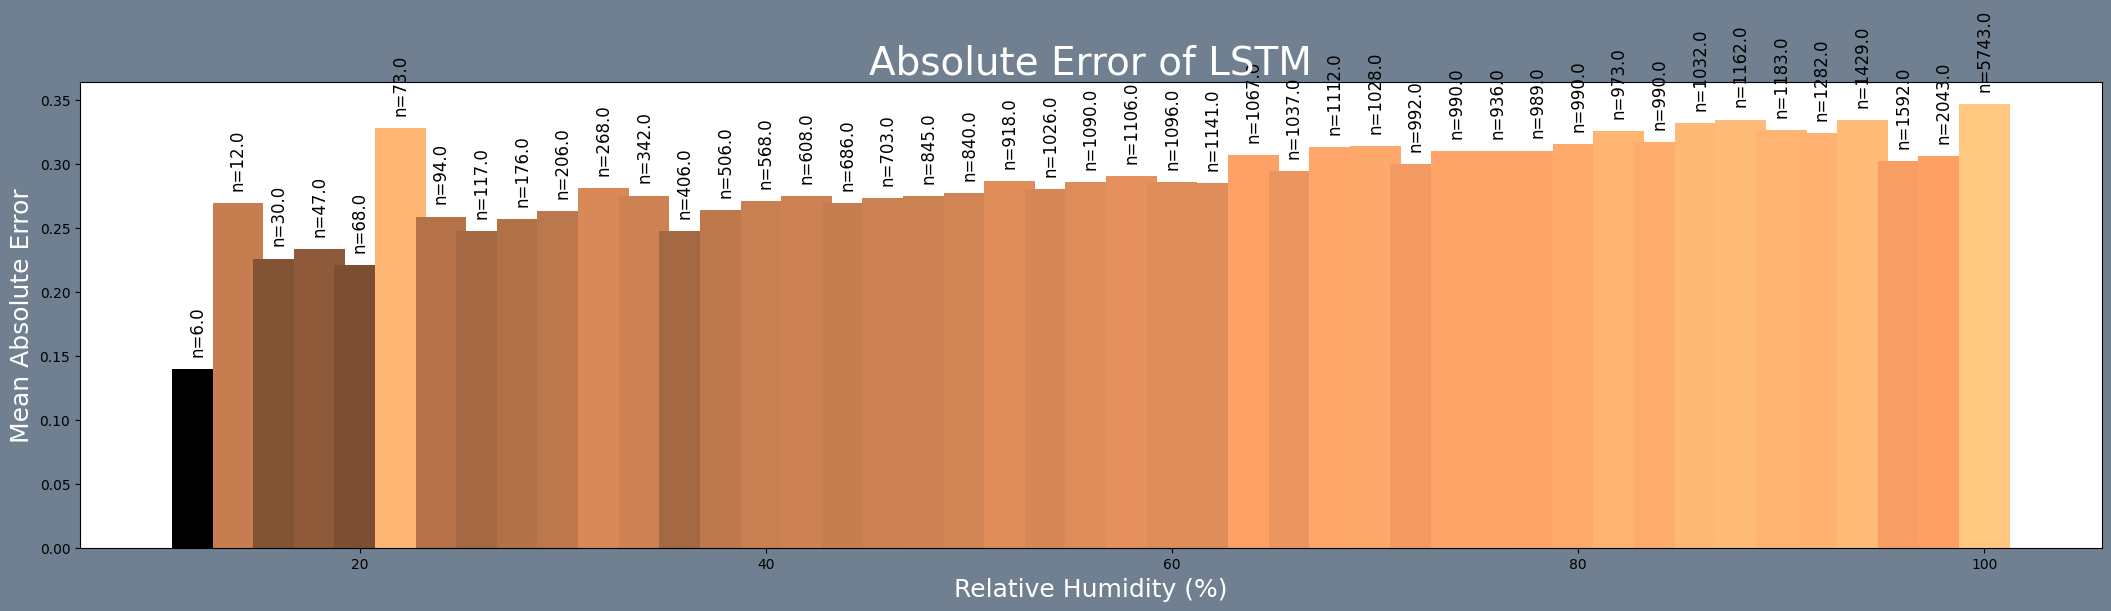

In [99]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 2.5)

In [100]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

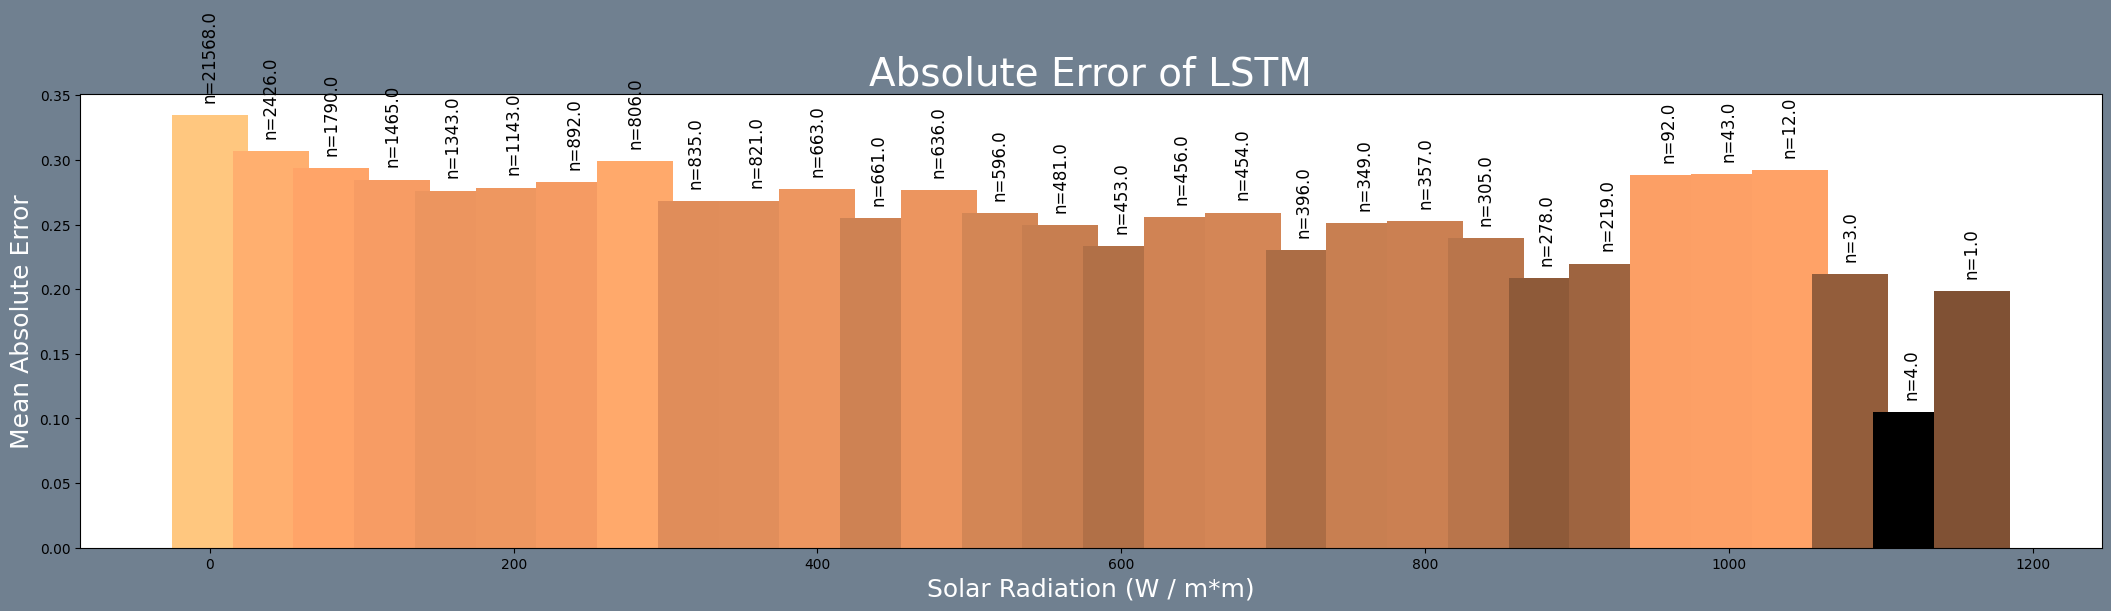

In [101]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [102]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

In [103]:
full_df[f"pres_{station}"].mean()

997.3985

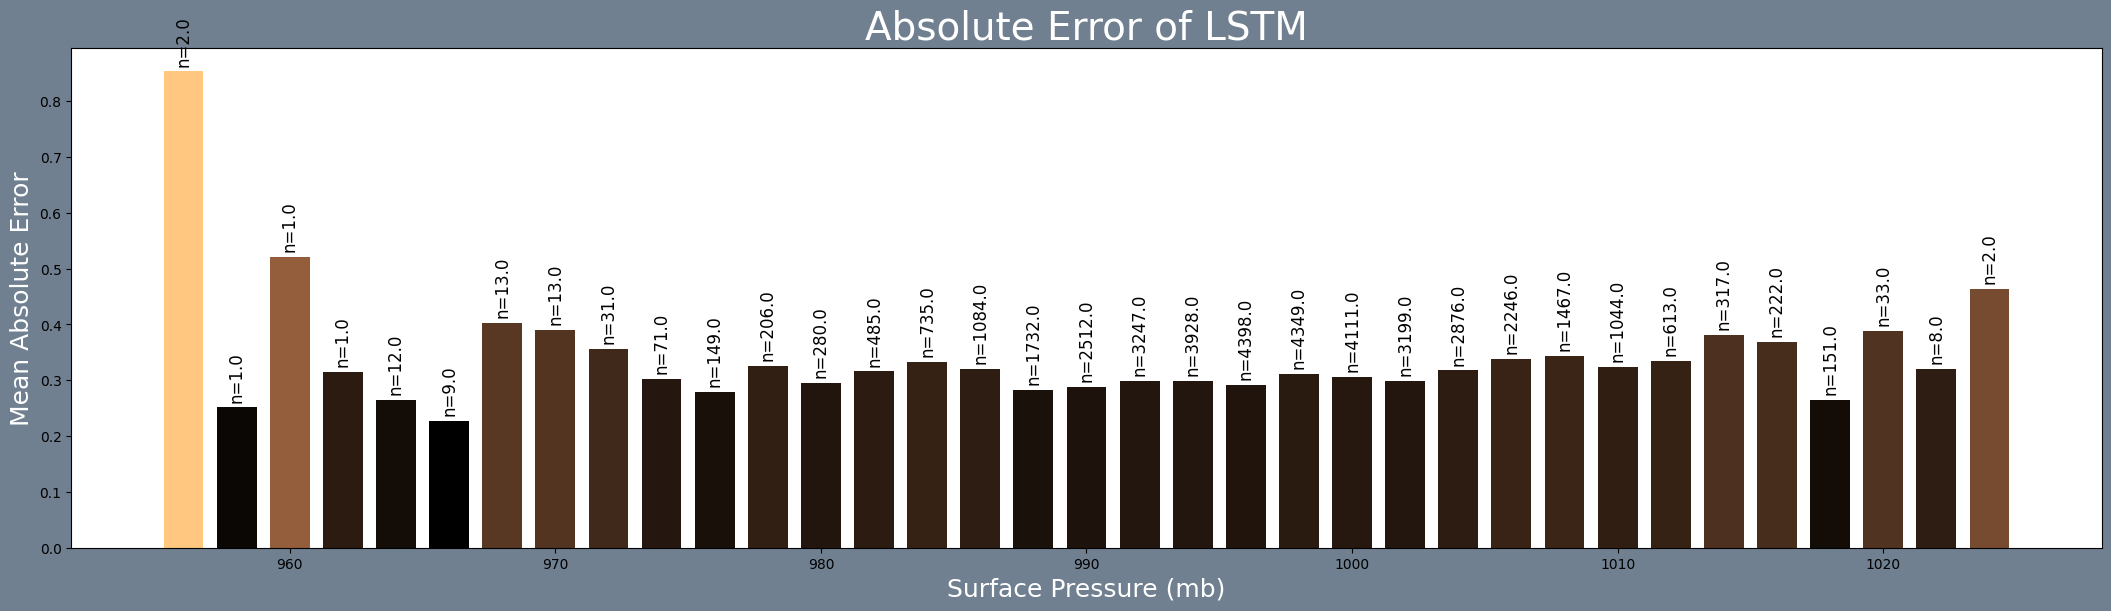

In [104]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [105]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [106]:
rain_df, instances = err_bucket(full_df, f"new_tp_{station}", 2)

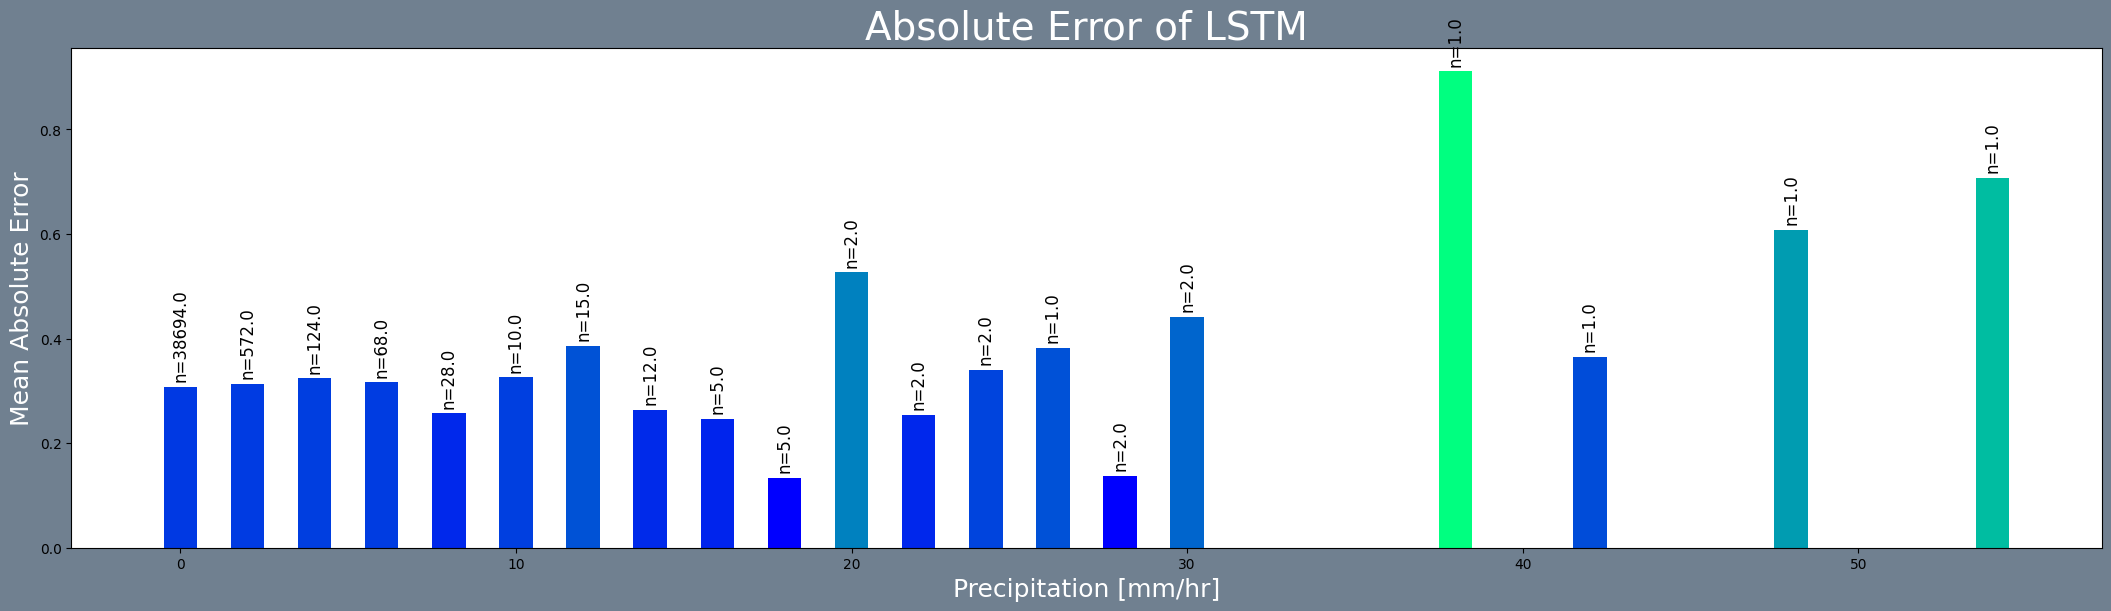

In [107]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 1.0)

In [108]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

In [109]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

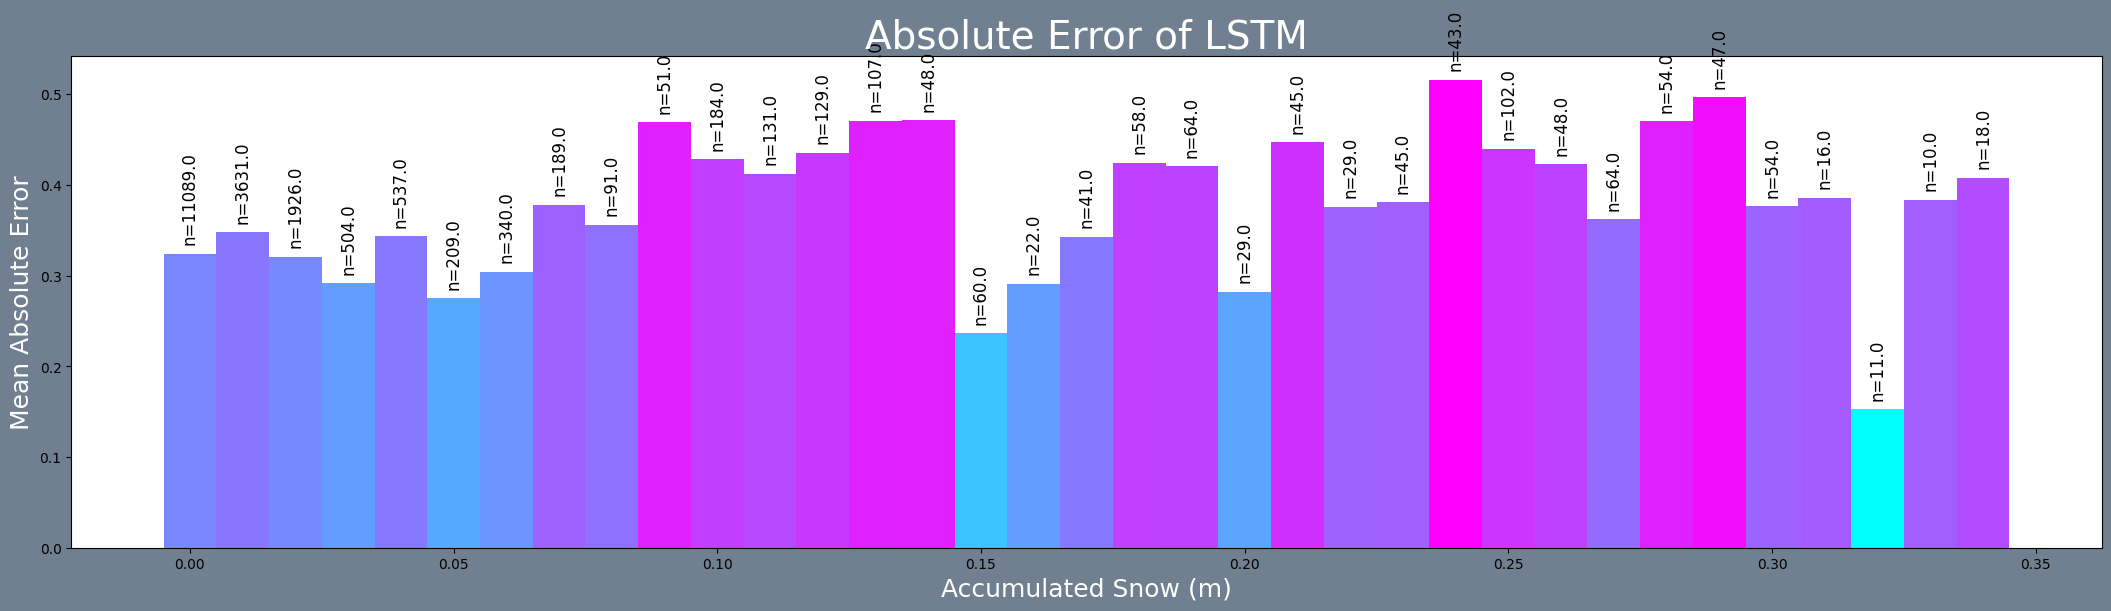

In [110]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [111]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

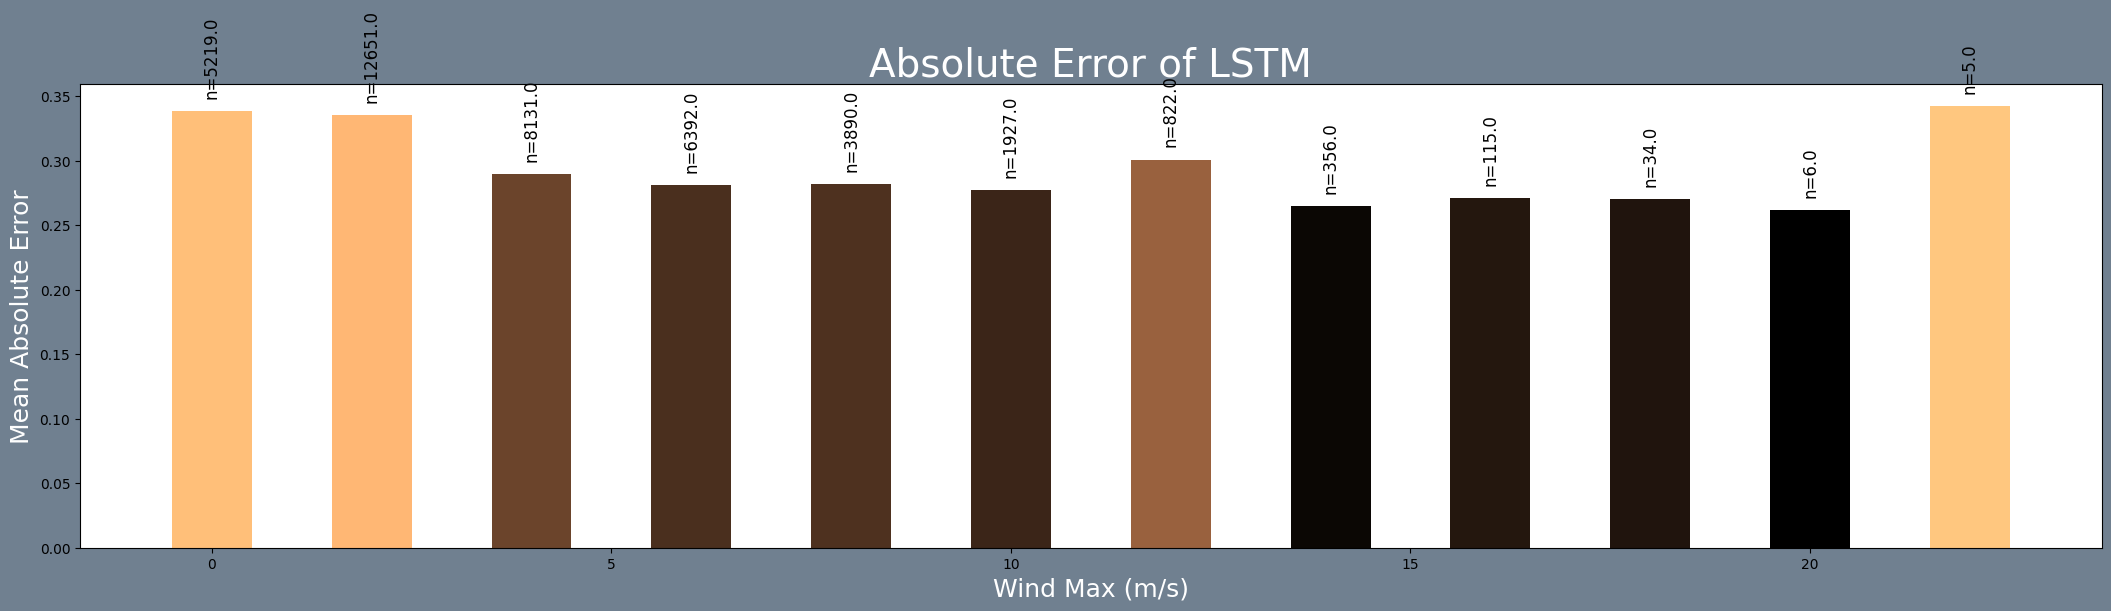

In [112]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)